# ASTR 598 HW1
# Hayden Smotherman, Chris Suberlak, Bryce Bolin, Winnie Wang

In [175]:
%matplotlib inline
import astropy.visualization as vis
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os
import numpy as np
import urllib.request
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization import (MinMaxInterval, ManualInterval, SqrtStretch,
                                   ImageNormalize)

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table
from astropy.table import hstack
from astropy.table import vstack
from astropy import wcs
from itertools import product
from scipy.stats import binned_statistic as bs
from scipy.stats import binned_statistic_2d as bs2d 
from astroML.plotting import setup_text_plots

Workflow : 
    
  1) from  http://das.sdss.org/va/stripe_82_variability/SDSS_82_public/
download eight HLC*fits.gz files
  
  2) For each HLC file, and separately for stars and galaxies (use MEAN_OBJECT_TYPE > 5 to classify stars), make a 3-panel plot with one panel showing the Hess (counts) r vs. g-i diagram and another two using isoplets for counts and color scheme to show the median RA and Dec proper motions.

  3) Make a few other interesting and judiciously chosen plots!


In [2]:
# https://github.com/astroML/astroML/blob/master/astroML/datasets/sdss_sspp.py
# fetch_sdds_ssp() is there 

catalogs = ['HLC.RA_20_to_21.fits.gz',
'HLC.RA_21_to_22.fits.gz',
'HLC.RA_22_to_23.fits.gz',
'HLC.RA_23_to_24.fits.gz',
'HLC.RA_00_to_01.fits.gz',
'HLC.RA_01_to_02.fits.gz',
'HLC.RA_02_to_03.fits.gz',
'HLC.RA_03_to_04.fits.gz']
for cat_name in catalogs : 
    if cat_name not in os.listdir():
        print('Downloading ...', cat_name)# if not, download it ...
        url = 'http://das.sdss.org/va/stripe_82_variability/SDSS_82_public/' + cat_name
        urllib.request.urlretrieve(url, cat_name)

From http://das.sdss.org/va/stripe_82_variability/SDSS_82_public/ : 
"The Light-Motion-Curve Catalogue (LMCC) covers Stripe 82 from RA = 20.7h to 3.3h and from Dec. = -1.26 deg to 1.26 deg, which equates to ~249 square degrees. This Stripe has been repeatedly monitored in the u, g, r, i and z bands over a seven-year baseline. The resulting catalogue contains almost 4 million light-motion curves of stellar objects and galaxies. Along with the LMCC, we supply a number of IDL plotting tools to aid in the visualisation of the light-motion-curves (see below).

We also provide what we refer to as the Higher-Level Catalogue (HLC) in 8 separate gzipped binary fits files. This catalogue supplies 235 derived quantities for each light-motion-curve, aimed at describing mean magnitudes, photometric variability and astrometric motion.
A detailed description of both the LMCC and HLC is available in the paper of Bramich et al. (2008)."

In [3]:
def ReadTable(name):
    hlc_fits = fits.open(name)
    hlc_table = Table(hlc_fits[1].data)
    return hlc_table

# so the table 'squashed' all five filters into 5 measurements per row... Unpack these:
# We assume these are standard u,g,r,i,z 
def FormatMagnitude(table):
    mean_psfmag = Table(table['MEAN_PSFMAG'], names=('u', 'g', 'r', 'i','z'))
    mean_psfmag_err = Table(table['MEAN_PSFMAG_ERR'], names=('u', 'g', 'r', 'i','z'))
    SN = {} #a dictionary
    for f in mean_psfmag.colnames : 
        SN[f] = mean_psfmag[f] / mean_psfmag_err[f]
    return mean_psfmag, mean_psfmag_err, SN

def PlotProperMotion(table):
    ra_pm = table['RA_PM_CLIP']
    dec_pm = table['DEC_PM_CLIP']
    plt.figure(figsize=(8,12))
    for quantity in [ra_pm, dec_pm]:
        mask = (0<np.abs(quantity)) * (np.abs(quantity)<0.03)
        plt.hist(quantity[mask], lw=2, bins=20, histtype='step')

In [190]:
def PlotHess(hlc_table,object_type="Stars",name="no_name", verbose=False,
            plot_dynamics=False):
    mean_psfmag, mean_psfmag_err, SN = FormatMagnitude(hlc_table)
    x_label = r'$\mathrm{g-i}$'
    y_label = r'$\mathrm{r}$'
    
    # extract the ra range for the HLC file from the catalog name 
    ramin = catalog_name[len('HLC.RA_'):len('HLC.RA_')+2]
    ramax = catalog_name[-2-len('.fits.gz'):-len('.fits.gz')]
    ra_title = ramin+r'$<$' +'RA'+ r'$<$' +ramax + '[hr]'
    if (object_type=="Stars"):
        mObject = hlc_table['MEAN_OBJECT_TYPE'].data == 6
        x_min, x_max, y_min, y_max = 0,1.5,15,23
        num_bins = 100
    elif object_type == "Galaxies":
        mObject = (hlc_table['MEAN_OBJECT_TYPE'].data == 3)
        x_min, x_max, y_min, y_max = 0,3,17,23
        num_bins = 50
    else:
        print("Can only handle stars and galaxies")
        return
        
    setup_text_plots(fontsize=15, usetex=True)

    # select only high signal to noise :
    mSN = (SN['g'] > 5) * ( SN['r'] > 5) * ( SN['i'] > 5 )

    # select reasonable color range
    gi = mean_psfmag['g'] - mean_psfmag['i']
    r = mean_psfmag['r']

    m_gi =  (x_min<gi) * (gi<x_max)
    m_r = (y_min<r) * (r<y_max)

    # select the PM range that makes sense
    pm_ra = np.abs(hlc_table['RA_PM_CLIP'].data)
    pm_dec = np.abs(hlc_table['DEC_PM_CLIP'].data)

    lower_cutoff = 1e-4
    upper_cutoff = 0.03
    m_pm_ra = (lower_cutoff<pm_ra)*(pm_ra < upper_cutoff)
    m_pm_dec =  (lower_cutoff<pm_dec)*(pm_dec<upper_cutoff)

    # combine the masks
    m = mSN * mObject * m_gi * m_r * m_pm_ra * m_pm_dec
    nObjects = np.sum(m)
    
    # plotted quantities  
    x = mean_psfmag['g'][m] - mean_psfmag['i'][m]
    y = mean_psfmag['r'][m]
    ra = np.abs(hlc_table['RA_PM'].data[m])
    dec =  np.abs(hlc_table['DEC_PM'].data[m])

    # use binned_statistic2d  ....
    N = bs2d(x,y,x, 'count', bins=num_bins)
    RA_med = bs2d(x,y,ra,statistic='median', bins=num_bins)
    DEC_med = bs2d(x,y,dec,statistic='median', bins=num_bins)
    cmin = min(np.log10(N.statistic.T[N.statistic.T >  0]))+ 0.1
    cmax = max(np.log10(N.statistic.T[N.statistic.T >  0]))- 0.1
    
    if (object_type == "Stars"):
        levels = np.linspace(cmin, cmax, 6)[3:]
    elif object_type == "Galaxies": 
        levels = np.linspace(cmin, cmax, 5)[2:]
        # 0, np.log10(N.statistic.max())
    else:
        error("Can only handle stars and galaxies")

    # Define custom colormaps: Set pixels with no sources to white
    cmap = plt.cm.viridis
    cmap.set_bad('w', 1.)

    cmap_multicolor = plt.cm.plasma # jet # inferno
    cmap_multicolor.set_bad('w', 1.)

    # Create figure and subplots
    fig = plt.figure(figsize=(15, 6))
    fig.subplots_adjust(wspace=0.22, left=0.1, right=0.95,
                    bottom=0.12, top=0.95)

    # set colorbar padding
    cbar_padding = 0.12

    #--------------------
    # First axes:
    ax = plt.subplot(131) 
    plt.imshow(np.log10(N.statistic.T), origin='lower',
               extent=[N.x_edge[0], N.x_edge[-1], N.y_edge[0], N.y_edge[-1]],
               aspect='auto', interpolation='nearest', cmap=cmap,
              vmax=2.5)
    plt.xlim(x_min,x_max)
    plt.ylim(y_min,y_max)
    # ticks=[0, 1, 2, 3] format=r'$10^{%i}$' 
    cb = plt.colorbar( pad=cbar_padding , orientation='horizontal')
    cb.set_label(r'$\log_{10}{(\mathrm{count})}$')
    plt.clim(cmin, cmax)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.gca().invert_yaxis()

    # set limits on colormap for RA, DEC proper motions 
    pm_min, pm_max = -2.8, -1.7
    
    # use Squared Stretch normalization ... 
    # http://docs.astropy.org/en/stable/visualization/normalization.html
    
    
    #--------------------
    # Second axes:
    ax = plt.subplot(132)

    # define tick location given the PM range ...
    #pm_ticks = [-0.04,-0.02,0,0.02,0.04]
    #pm_ticks = np.log10(np.array([-0.04,-0.02,0,0.02,0.04]))

    # color by median RA 
    image  = np.log10(RA_med.statistic.T)
    #norm = ImageNormalize(image, interval=ManualInterval(vmin=pm_min, vmax=pm_max),
                          #MinMaxInterval(),
    #                      stretch=SqrtStretch())
    #norm = ImageNormalize(stretch=SqrtStretch())
    plt.imshow(image, origin='lower',
               extent=[RA_med.x_edge[0], RA_med.x_edge[-1], 
                   RA_med.y_edge[0], RA_med.y_edge[-1]],
           aspect='auto', interpolation='nearest', 
           cmap=cmap_multicolor)# , norm=norm)
    #ticks=np.arange(-2.5, 1, 1)
    cb = plt.colorbar(pad=cbar_padding , orientation='horizontal')
    cb.set_label(r'$\log_{10}{(\mathrm{median}\, \mu_{\alpha}\, ) }$')
    plt.clim(pm_min, pm_max)

    # plot the contour of color counts 
    plt.contour(np.log10(N.statistic.T), levels, colors='k',
                extent=[N.x_edge[0], N.x_edge[-1], N.y_edge[0], N.y_edge[-1]],
               origin='lower')
    plt.xlim(x_min,x_max)
    plt.ylim(y_min,y_max)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.gca().invert_yaxis()

    #--------------------
    # Third axes:
    ax = plt.subplot(133)

    # color by median DEC
    image  = np.log10(DEC_med.statistic.T)
    #norm = ImageNormalize(image,interval=ManualInterval(vmin=pm_min, vmax=pm_max),
    #                      #MinMaxInterval(),
    #                       stretch=SqrtStretch())
    plt.imshow(image, origin='lower',
               extent=[DEC_med.x_edge[0], DEC_med.x_edge[-1], 
                       DEC_med.y_edge[0], DEC_med.y_edge[-1]],
               aspect='auto', interpolation='nearest', 
               cmap=cmap_multicolor)#,norm=norm )
    
    #ticks=np.arange(-2.5, 1, 1)
    cb = plt.colorbar(  pad=cbar_padding , orientation='horizontal')
    cb.set_label(r'$\log_{10}{(\mathrm{median}\, \mu_{\delta}\,)}$')
    plt.clim(pm_min,pm_max)

    # plot the contour of color counts 
    plt.contour(np.log10(N.statistic.T), levels, colors='k',
                extent=[N.x_edge[0], N.x_edge[-1], 
                        N.y_edge[0], N.y_edge[-1]],
                origin='lower')

    plt.xlim(x_min,x_max)
    plt.ylim(y_min,y_max)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.gca().invert_yaxis()
    # add title above the three panels
    fig.suptitle(str(nObjects)+' '+object_type + ' '+ra_title, y=0.99, fontsize=18)
    
    # save the plots 
    plt.savefig(name+'_'+object_type+'.png', bbox_inches='tight')
    
    # plot the histogram of proper motions 
    # add vertical lines at the locations of 
    # limits of raPM, decPM 
    if plot_dynamics :
        fig,ax = plt.subplots(1,1,figsize=(6,4))
        for q,l in zip([RA_med, DEC_med], [r'$\alpha$', r'$\delta$']) :
            x = np.ravel(q.statistic.T)    
            ax.hist(np.log10(x[x>0]), histtype='step',lw=2, label=l, bins=20)
        ax.axvline(pm_min,lw=2,ls='--', c='blue')
        ax.axvline(pm_max, lw=2, ls='--', c='blue')
        ax.set_title('Full range of proper motion')
        ax.set_ylabel('counts')
        ax.set_xlabel(r'$\log_{10}{(\mu [\mathrm{arcsec \,\,yr}^{-1}])}$')
        plt.legend(loc='upper left')
        plt.savefig(name+'_'+object_type+'_PM.png', bbox_inches='tight')
            
    if verbose : 
        return N, RA_med, DEC_med
    else:
        return

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: invalid value encountered in greater


Finished catalog HLC.RA_20_to_21.fits.gz


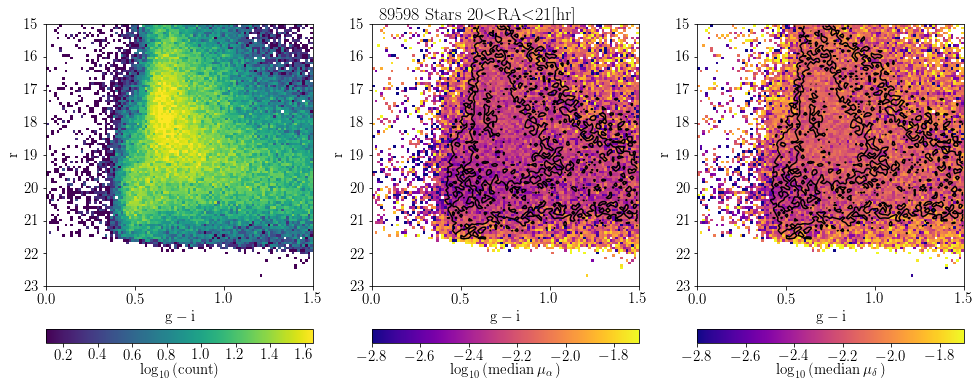

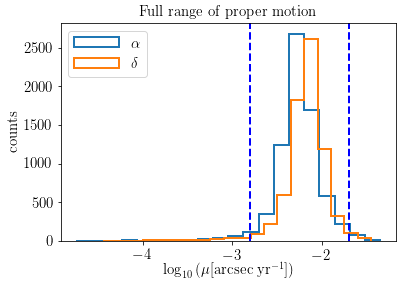

In [191]:
# Test on just one catalog and object type 
catalog_name = catalogs[0]
hlc_table = ReadTable(catalog_name)
for object_type in ["Stars"]:#, "Galaxies"]:
    N, RA_med, DEC_med = PlotHess(hlc_table, object_type=object_type, 
                                  name=catalog_name, verbose=True, 
                                  plot_dynamics=True)
    print("Finished catalog "+catalog_name)

plotting Hess diagrams for  Stars


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: invalid value encountered in greater


plotting Hess diagrams for  Galaxies
Finished catalog HLC.RA_20_to_21.fits.gz
plotting Hess diagrams for  Stars
plotting Hess diagrams for  Galaxies
Finished catalog HLC.RA_21_to_22.fits.gz
plotting Hess diagrams for  Stars
plotting Hess diagrams for  Galaxies
Finished catalog HLC.RA_22_to_23.fits.gz
plotting Hess diagrams for  Stars
plotting Hess diagrams for  Galaxies
Finished catalog HLC.RA_23_to_24.fits.gz
plotting Hess diagrams for  Stars
plotting Hess diagrams for  Galaxies
Finished catalog HLC.RA_00_to_01.fits.gz
plotting Hess diagrams for  Stars


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


plotting Hess diagrams for  Galaxies
Finished catalog HLC.RA_01_to_02.fits.gz
plotting Hess diagrams for  Stars
plotting Hess diagrams for  Galaxies
Finished catalog HLC.RA_02_to_03.fits.gz
plotting Hess diagrams for  Stars
plotting Hess diagrams for  Galaxies
Finished catalog HLC.RA_03_to_04.fits.gz


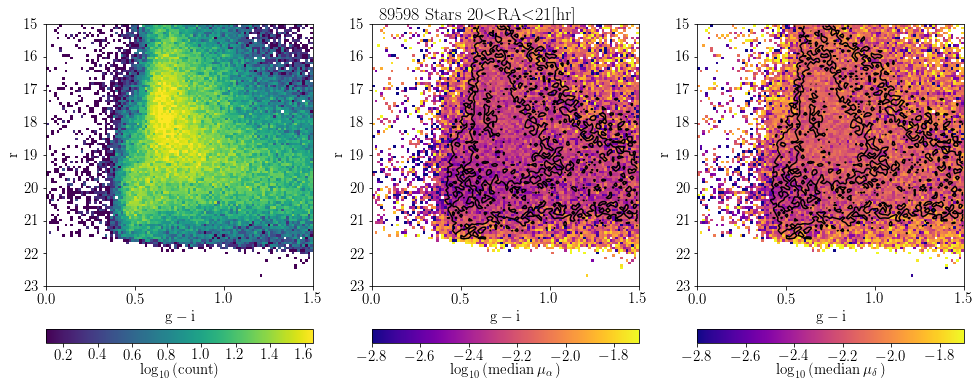

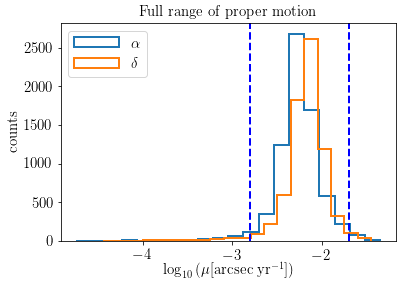

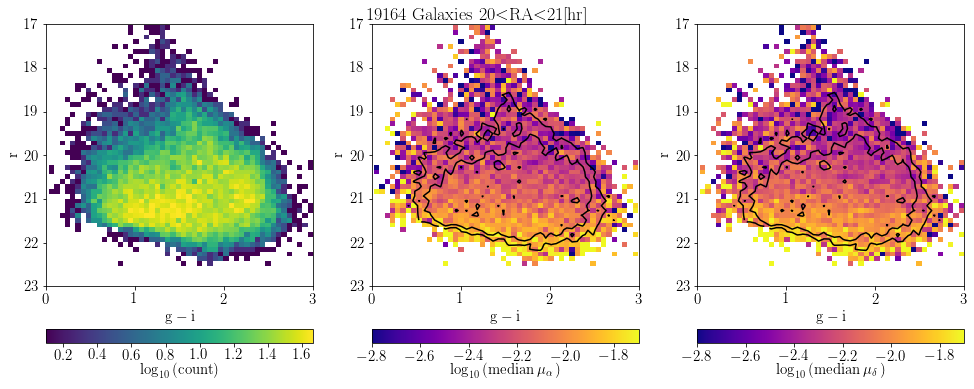

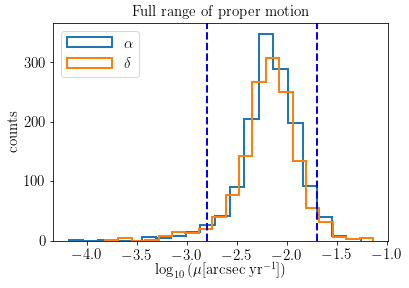

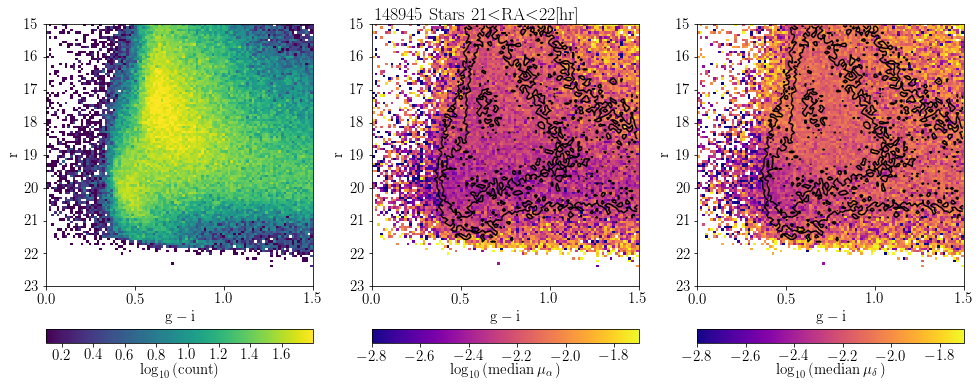

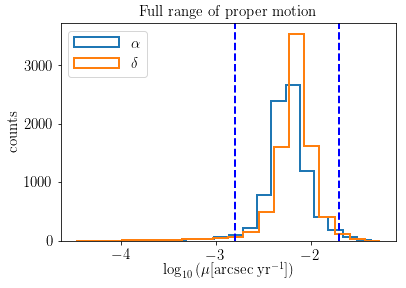

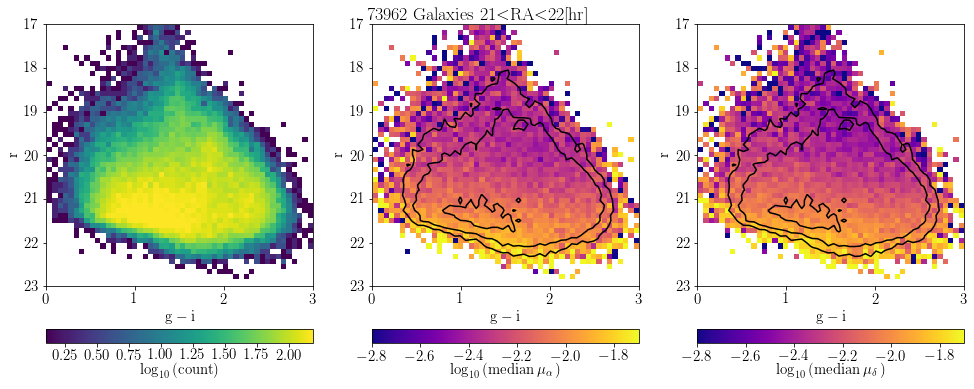

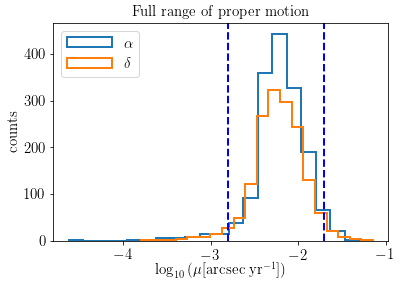

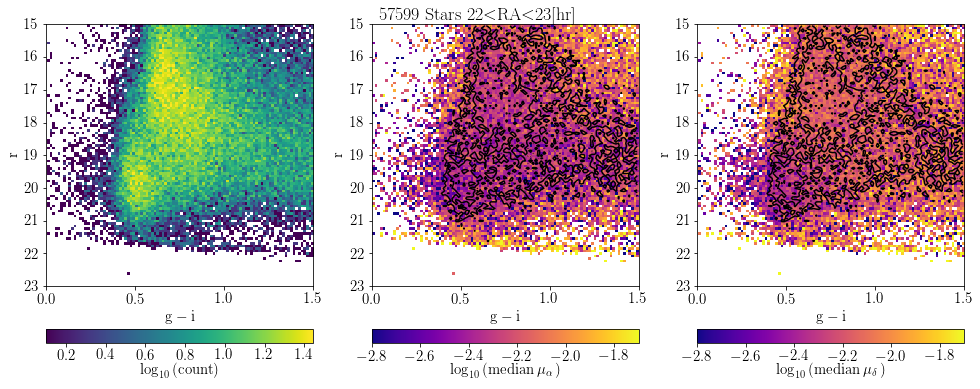

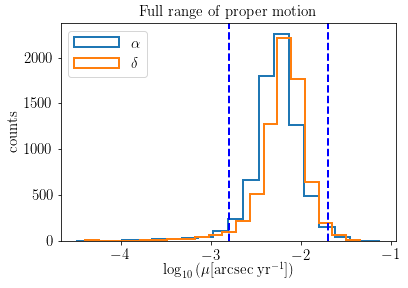

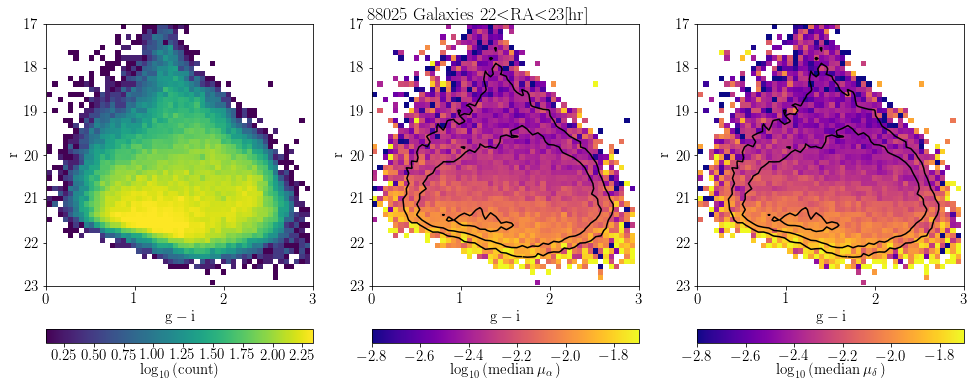

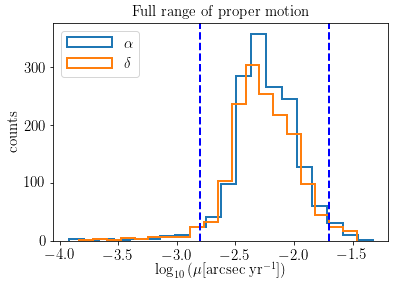

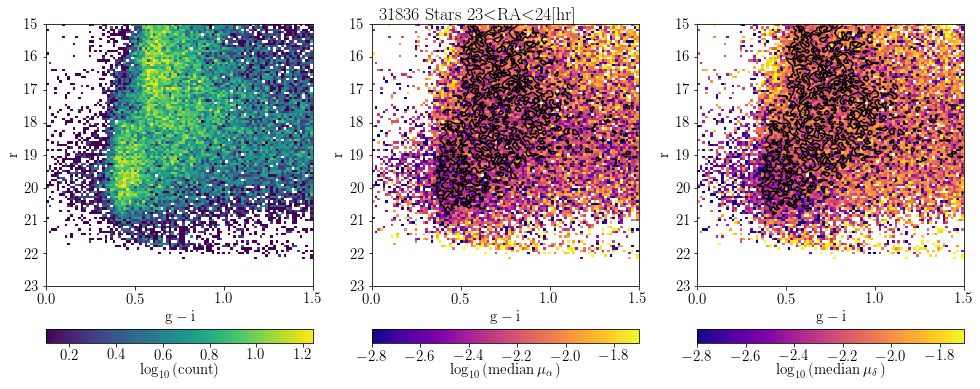

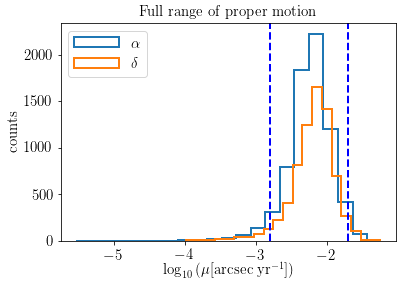

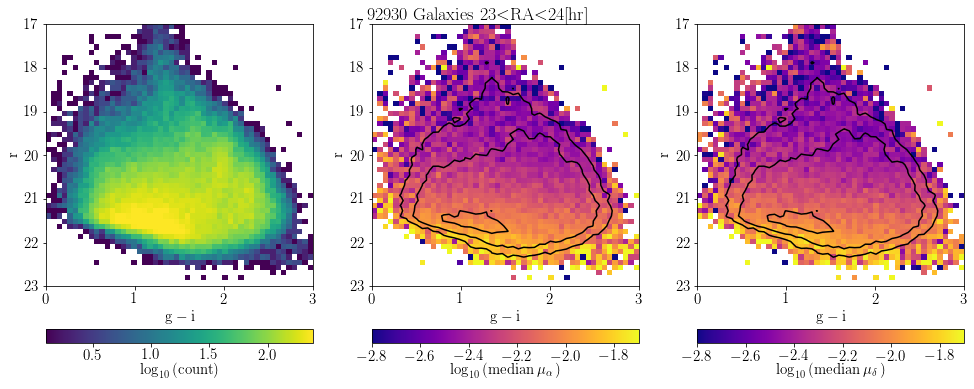

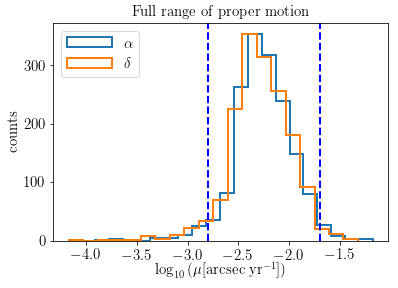

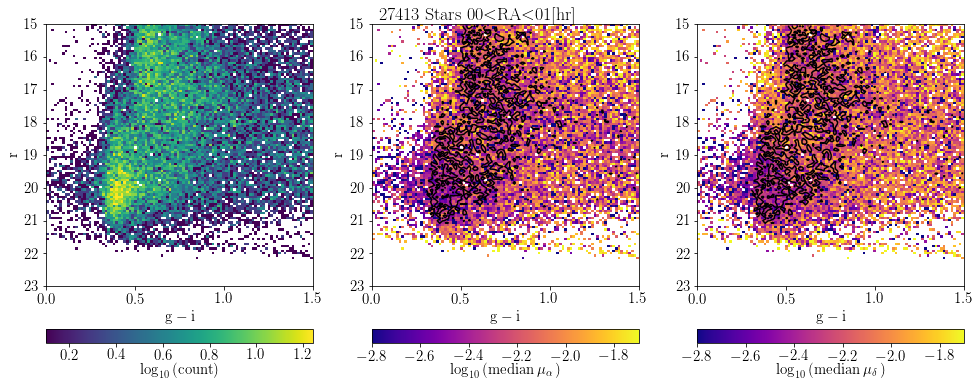

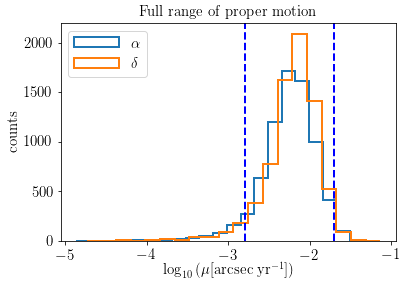

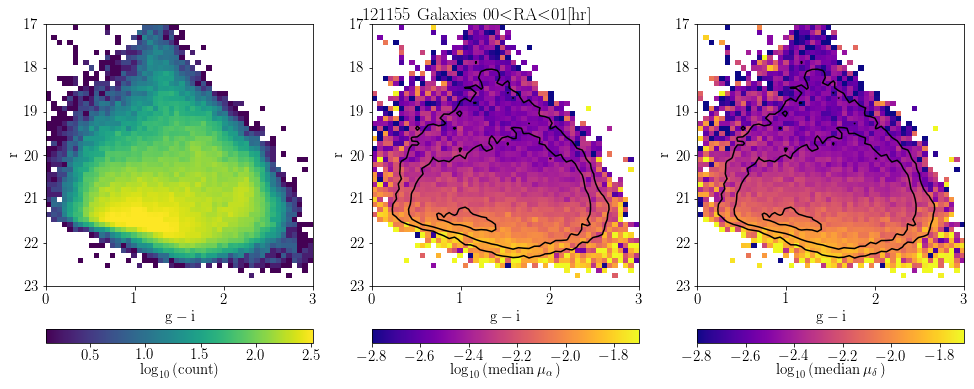

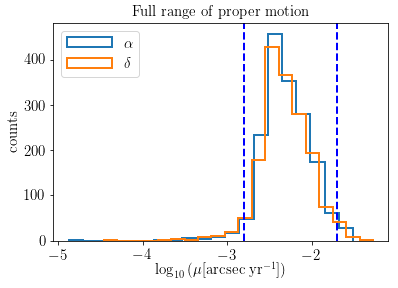

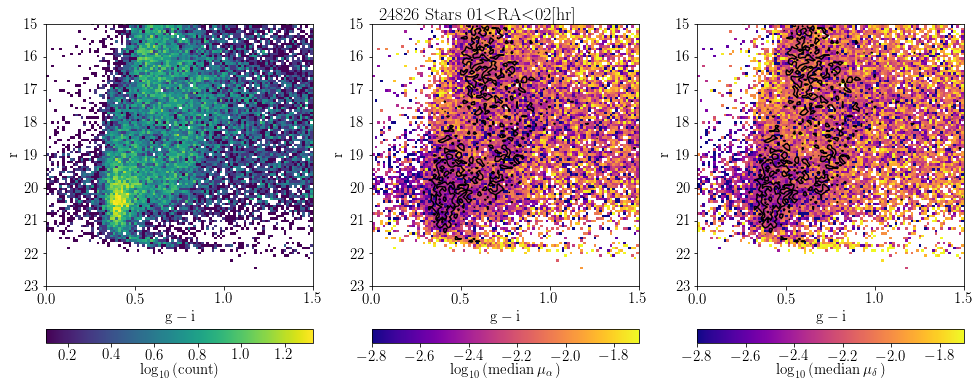

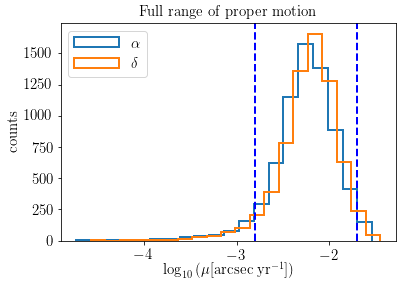

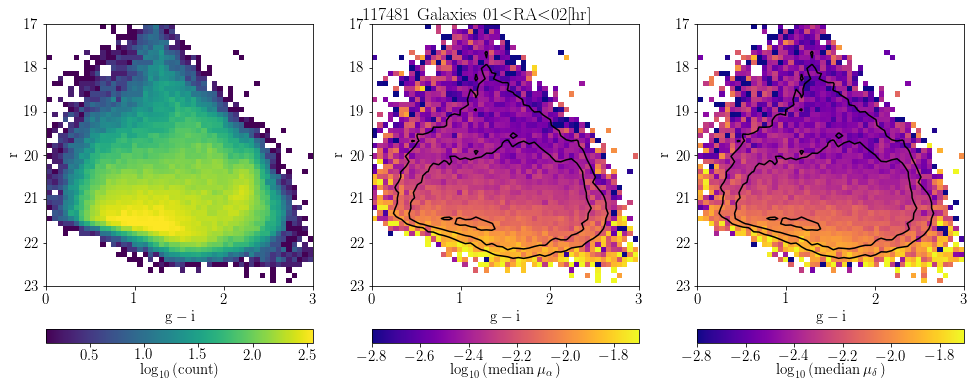

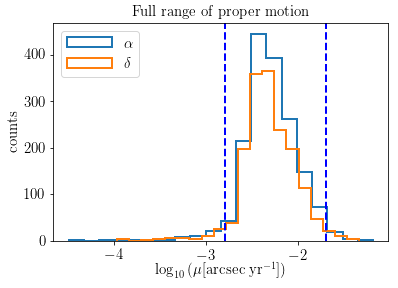

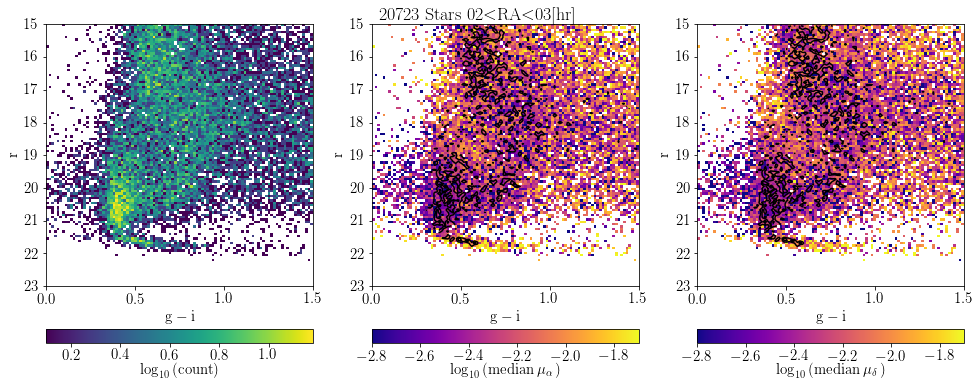

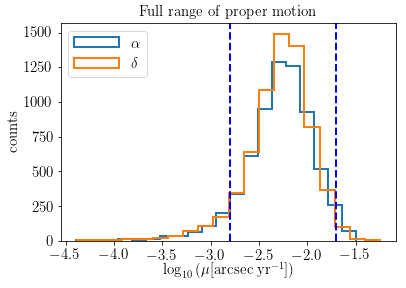

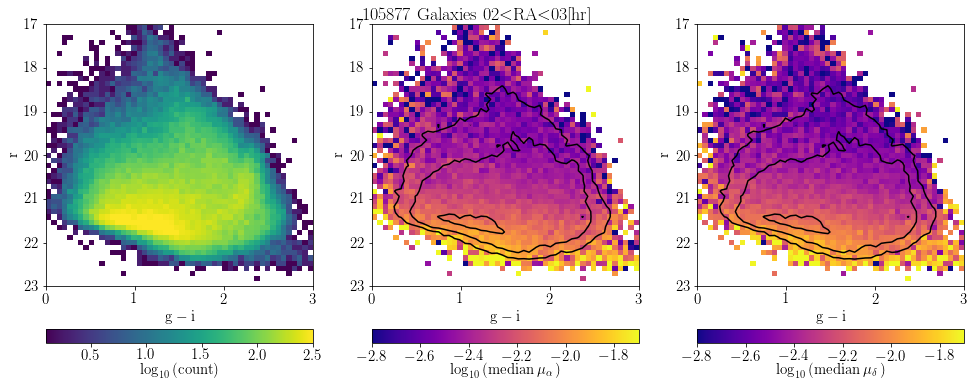

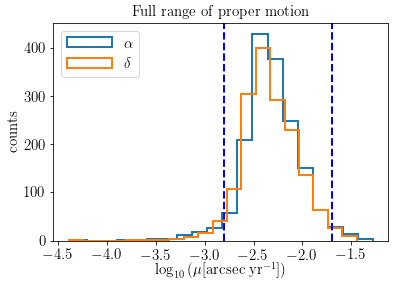

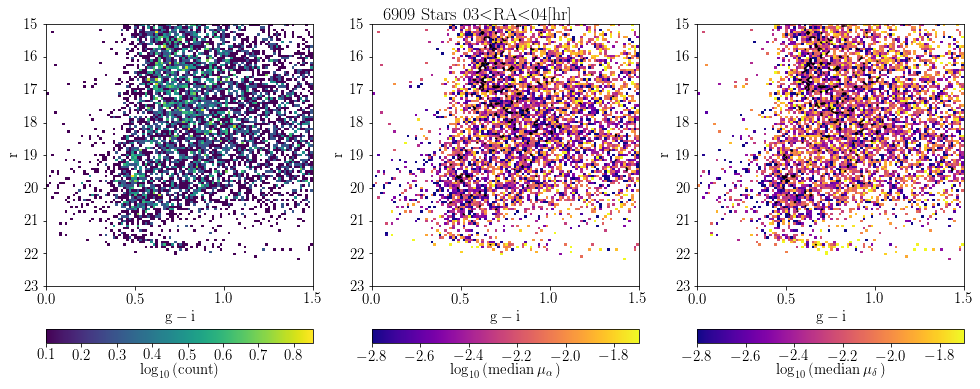

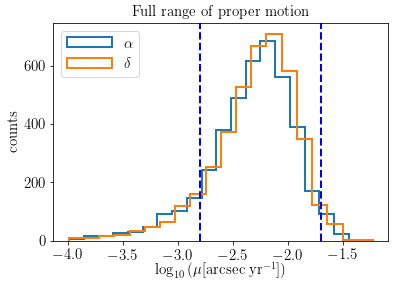

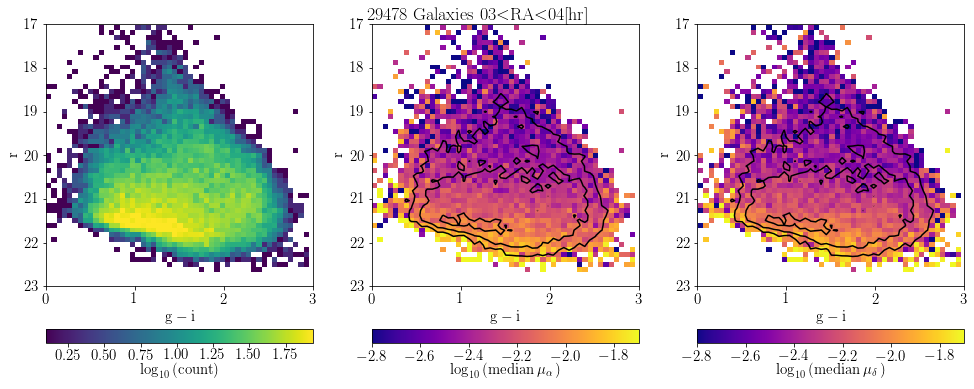

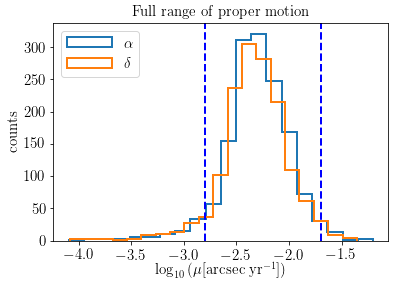

In [192]:
# loop over HLC files and object types,
# for each plotting the r vs g-i colored by counts  and 
# two other panels , colored by median proper motion in RA, and DEC
for catalog_name in catalogs:
    hlc_table = ReadTable(catalog_name)
    for object_type in ["Stars", "Galaxies"]:
        print('plotting Hess diagrams for ', object_type)
        PlotHess(hlc_table, object_type=object_type, name=catalog_name, 
                 plot_dynamics=True)
    print("Finished catalog "+catalog_name)